In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Input
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.optimizers import Adam

# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Load data
df = pd.read_csv('/root/autodl-tmp/7.18_SDGprediction/data/FB_SDG_3_A.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
# Prepare dataset for multivariate time series forecasting
def create_dataset_multivariate(data, time_steps=1, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps - forecast_steps + 1):
        X.append(data[i:(i + time_steps), :-1])
        y.append(data[(i + time_steps):(i + time_steps + forecast_steps), -1])
    return np.array(X), np.array(y)

time_steps = 30  # Adjust the time steps as necessary
forecast_steps = 7  # Predicting the next step

# Assuming all columns except the first are used as features
data = df.values
X, y = create_dataset_multivariate(data, time_steps, forecast_steps)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Train and predict with LSTM
print("Training LSTM...")
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train.shape[2])))
lstm_model.add(Dense(forecast_steps))
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)
lstm_pred = lstm_model.predict(X_test_lstm).reshape(y_test.shape)

# Train and predict with GRU
print("Training GRU...")
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
gru_model = Sequential()
gru_model.add(Input(shape=(time_steps, X_train.shape[2])))
gru_model.add(GRU(50, activation='relu', return_sequences=True))
gru_model.add(GRU(50, activation='relu'))
gru_model.add(Dense(forecast_steps))
optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mse')
gru_model.fit(X_train_gru, y_train, epochs=50, batch_size=32, verbose=1)
gru_pred = gru_model.predict(X_test_gru).reshape(y_test.shape)


Training LSTM...
Epoch 1/50


/root/autodl-tmp/miniconda3/envs/cytf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.6683
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3859
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2105
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1852
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1751
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1693
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1654
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1622
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1593
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1564
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1542
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1523
Epoch 13/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1505
Epoch 14/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1486
Epoch 15/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1469
Epoch 16/50
64/

In [7]:
lstm_pred.shape

(509, 7)

In [8]:

# Evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    return mse, mae


In [9]:

# Predictions from LSTM and GRU models
models = {
    'LSTM': lstm_pred,
    'GRU': gru_pred
}
results = {}

# Calculate MSE and MAE for each model
for model_name, predictions in models.items():
    mse, mae = evaluate_model(y_test, predictions)
    results[model_name] = {'MSE': mse, 'MAE': mae}

# Convert results to DataFrame for viewing
mse_df = pd.DataFrame({model: results[model]['MSE'] for model in results.keys()})
mae_df = pd.DataFrame({model: results[model]['MAE'] for model in results.keys()})

# Calculate overall MSE and MAE
overall_mse = mse_df.mean()
overall_mae = mae_df.mean()

# Display results
print("\nMSE for each time step:")
print(mse_df)
print("\nMAE for each time step:")
print(mae_df)

print("\nOverall MSE for each model:")
print(overall_mse)
print("\nOverall MAE for each model:")
print(overall_mae)



MSE for each time step:
       LSTM       GRU
0  1.269323  0.399805
1  2.751229  0.550110
2  2.040828  0.529805
3  3.257808  0.428536
4  2.390001  0.484195
5  1.391308  0.480409
6  1.628401  0.496482

MAE for each time step:
       LSTM       GRU
0  0.522342  0.418266
1  0.711771  0.485285
2  0.623713  0.468805
3  0.720780  0.435512
4  0.664966  0.454073
5  0.569805  0.469714
6  0.608160  0.458808

Overall MSE for each model:
LSTM    2.104128
GRU     0.481335
dtype: float64

Overall MAE for each model:
LSTM    0.631648
GRU     0.455780
dtype: float64


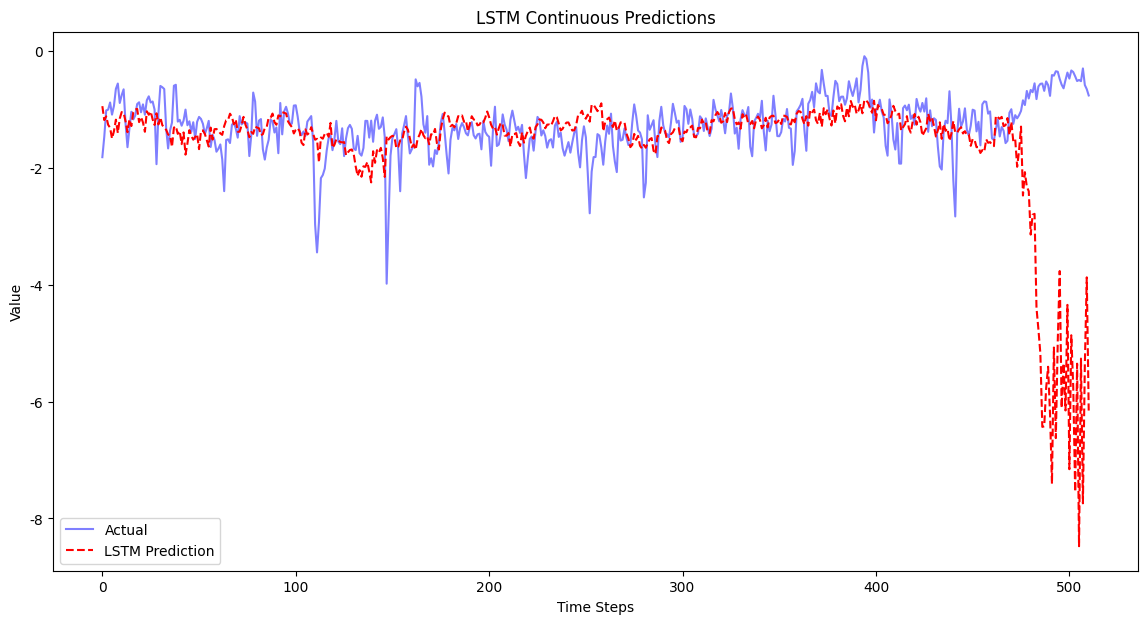

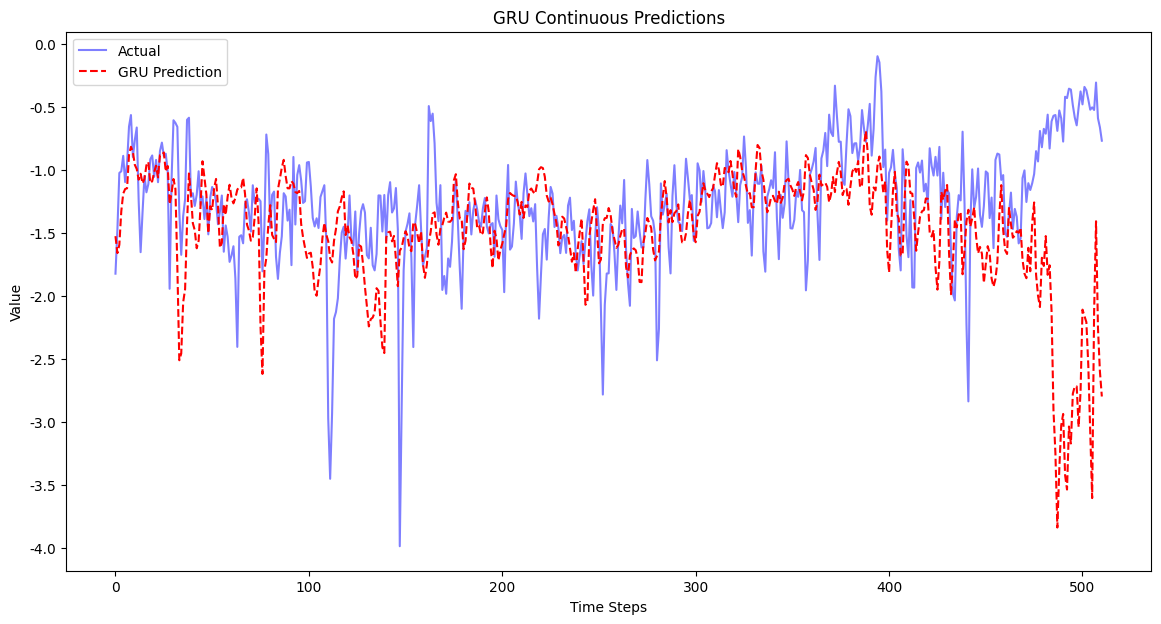

In [10]:
# Plot continuous predictions
def plot_continuous_predictions(y_test, predictions, model_name, forecast_steps):
    # Concatenate predictions and actual values for continuous plotting
    continuous_predictions = np.concatenate(predictions[::forecast_steps])
    continuous_actual = np.concatenate(y_test[::forecast_steps])
    
    plt.figure(figsize=(14, 7))
    plt.plot(continuous_actual, color='blue', label='Actual', alpha=0.5)
    plt.plot(continuous_predictions, linestyle='dashed', color='red', label=f'{model_name} Prediction')
    plt.title(f'{model_name} Continuous Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Plot predictions for each model
for model_name, predictions in models.items():
    plot_continuous_predictions(y_test, predictions, model_name, forecast_steps)
